# I. Imports and installations

In [ ]:
!pip install -U -q PyDrive
!pip install seaborn

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, FloatLogSlider, IntRangeSlider
import ipywidgets as widgets

# II. Portfolio management

## 1. Main functions of the portfolio management

### 1.1 Monte Carlo Sampling

In [ ]:
def sampling(nb_companies, nb_sectors, nb_simulations):
  "Input : Number of companies, simulations and sectors"
  "Output a Monte Carlo sampling of each variable"
  samples = np.random.randn(nb_simulations, nb_companies+nb_sectors+1)
  df_samples = pd.DataFrame(samples, columns= ['X'] + ['X'+str(i) for i in range(1,nb_sectors+1)] + ['E'+str(i) for i in range(1,nb_companies+1)], index=[i for i in range(1,nb_simulations+1)])
  return df_samples

### 1.2. The loss computing

In [ ]:
def spreads(df_portfolio, df_samples, nb_companies, nb_simulations, rho):
  "Input : Portfolio dataframe, numbers of companies and simulations, the global correlation"
  "Output : Dataframe of the spreads"
  df_spreads = pd.DataFrame(columns=['Z'+str(i) for i in range(1,nb_companies+1)], index=[i for i in range(1,nb_simulations+1)])
  for i in range(1,nb_companies+1):
    df_spreads['Z'+str(i)] = math.sqrt(rho)*df_samples['X'] + math.sqrt(df_portfolio['Correlation'][i]-rho)*df_samples['X'+str(df_portfolio['Sector'][i])]+math.sqrt(1-df_portfolio['Correlation'][i])*df_samples['E'+str(i)]
  return df_spreads

def barriers(df_portfolio, maturity):
  "Input : The dataframe of the portfolio and the maturity desired"
  "Output : The barriers of the portfolio"
  return norm.ppf(df_portfolio[maturity])

def defaults(df_portfolio, df_spreads, maturity, nb_companies, nb_simulations):
  "Input : The dataframe of the portfolio, the numbers of companies and simulations"
  "Output : The defaults of the portfolio"
  df_defaults = pd.DataFrame(columns=['D'+str(i) for i in range(1,nb_companies+1)], index=[i for i in range(1,nb_simulations+1)])
  for i, column in enumerate(df_spreads, 1):
    df_defaults['D'+str(i)]=(df_spreads[column]<df_portfolio['Barriers ' + maturity][i])*1
  return df_defaults

def loss(df_defaults, df_portfolio, nb_companies, nb_simulations):
  "Input : The dataframe of the portfolio, the dataframe of the defaults, the numbers of companies and simulations"
  "Output : The loss of the portfolio"
  df_loss = pd.DataFrame(columns=['Loss '+str(i) for i in range(1,nb_companies+1)], index=[i for i in range(1,nb_simulations+1)])
  for i, column in enumerate(df_defaults, 1):
    df_loss['Loss '+str(i)] = df_defaults[column]*df_portfolio['Exposure'][i]*df_portfolio['LGD'][i]
  return df_loss

### 1.3. The portfolio indicators

In [ ]:
def valueAtRisk(df_losses, confidence):
  "Input : The losses of the portfolio for each simulation and the confidence required"
  "Output : The Value at Risk of the portfolio"
  return df_losses['Losses'].quantile(confidence)

def meanLosses(df_losses):
  "Input : The losses of the portfolio for each simulation"
  "Output : The average losses of the portfolio"
  return df_losses['Losses'].mean()

def expectedLoss(df_portfolio, maturity):
  "Input : The losses of the portfolio for each simulation"
  "Output : The expected loss for each company"
  return df_portfolio[maturity]*df_portfolio['LGD']*df_portfolio['Exposure']

def sumExpectedLosses(df_portfolio):
  "Input : The losses of the portfolio for each simulation"
  "Output : The global expected loss of the portfolio"
  return df_portfolio['Expected loss'].sum()

def expectedShortfall(df_losses, valueAtRisk):
  "Input : The losses of the portfolio for each simulation"
  "Output : The expected shortfall of the portfolio"
  nb_values=(df_losses['Losses']>valueAtRisk).sum()
  return (df_losses['Losses'][df_losses['Losses']>valueAtRisk]).sum()/nb_values

def portfolioIndicators(confidence, df_losses, df_portfolio, maturity):
  "Input : The losses of the portfolio for each simulation"
  "Output : The portfolio's indicators"
  vAtRisk = valueAtRisk(df_losses, confidence) # Compute the Value at Risk
  mean_losses = meanLosses(df_losses) # Compute the average losses of the portfolio
  df_portfolio['Expected loss'] = expectedLoss(df_portfolio, maturity) # Compute the expected loss of the portfolio
  sum_expected_losses = df_portfolio['Expected loss'].sum() # Compute the average expected loss of the portfolio
  expectedShortFall = expectedShortfall(df_losses, vAtRisk)
  return pd.DataFrame({'Value at Risk' : vAtRisk, 'Average losses' : mean_losses, 'Expected losses' : sum_expected_losses, 'Expected Shortfall' : expectedShortFall}, index=[1])

### 1.4. The analysis of losses

In [ ]:
def rollingMean(df_losses):
  "Input : The losses of the portfolio for each simulation"
  "Output : The rolling mean of the losses of the portfolio"
  return df_losses['Losses'].expanding().mean()

def plotRollingMean(df_losses, df_portfolio_indicators):
  "Input : The losses dataframe of the portfolio for each simulation and the portfolio indicators dataframe"
  plotedRollingMean = df_losses['Rolling mean'].plot(color='b',linewidth=2.5)
  plotedRollingMean.set_label('Loss rolling mean')
  expectedLoss = plotedRollingMean.axhline(df_portfolio_indicators['Expected losses'][1], color='r', linestyle='--')
  expectedLoss.set_label('Expected loss')
  plotedRollingMean.legend(['Rolling mean', 'Expected loss'])
  plotedRollingMean.set_ylabel('Average loss of the portfolio')
  plotedRollingMean.set_xlabel('Number of simulations')
  plotedRollingMean.set_title('Convergence of the average loss')
  return plotRollingMean

def rollingStdev(df_losses):
  "Input : The losses of the portfolio for each simulation"
  "Output : The rolling standard deviation of the losses of the portfolio"
  return df_losses['Losses'].expanding().std()

def plotRollingStdev(df_losses):
  "Input : The losses dataframe of the portfolio for each simulation"
  plotRollingStdev = df_losses['Rolling stdev'].plot(color='b',linewidth=2.5)
  plotRollingStdev.set_label('Rolling standard deviation')
  plotRollingStdev.legend(['Rolling standard deviation'])
  plotRollingStdev.set_ylabel('Standard deviation of the loss of the portfolio')
  plotRollingStdev.set_xlabel('Number of simulations')
  plotRollingStdev.set_title('Convergence of the standard deviation of the loss')
  return plotRollingStdev

def losses(df_portfolio, maturity, nb_companies, nb_sectors, nb_simulations, rho):
  "Input : parameters dataframe, portfolio dataframe"
  "Output : the losses of the portfolio for each simulation"
  df_samples = sampling(nb_companies, nb_sectors, nb_simulations) # Monte Carlo sampling
  df_spreads = spreads(df_portfolio, df_samples, nb_companies, nb_simulations, rho) # Compute the spreads
  df_portfolio['Barriers ' + maturity] = barriers(df_portfolio, maturity) # Compute the barriers
  df_defaults = defaults(df_portfolio, df_spreads, maturity, nb_companies, nb_simulations) # Compute the defaults
  df_loss = loss(df_defaults, df_portfolio, nb_companies, nb_simulations) # Compute the loss
  df_losses = pd.DataFrame(columns=['Losses', 'Rolling mean', 'Rolling stdev'], index=[i for i in range(1,nb_simulations+1)]) # Compute the losses of the portfolio of each simulation
  df_losses['Losses'] = df_loss.sum(axis = 1)
  df_losses['Rolling mean'] = rollingMean(df_losses) # Compute the rolling mean
  df_losses['Rolling stdev'] = rollingStdev(df_losses) # Compute the rolling standard deviation
  return df_losses

## 2. The study of the portfolio management

### 2.1. Data preprocessing

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1Fx8p4A9mjzqUCIT6piNN2atUwH7U2yzZ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Portfolio.xlsx')  
df_param, df_portfolio, df_rating, df_sector, df_cdoTranch = pd.read_excel('Portfolio.xlsx', sheet_name='Param'), pd.read_excel('Portfolio.xlsx', sheet_name='Portfolio'), pd.read_excel('Portfolio.xlsx', sheet_name='Rating'), pd.read_excel('Portfolio.xlsx', sheet_name='Sector'),pd.read_excel('Portfolio.xlsx', sheet_name='CDO Tranch')

In [ ]:
# Data processing
df_portfolio = df_portfolio.merge(df_rating,how='left', on='Rating',sort=False).merge(df_sector,how='left', on='Sector',sort=False)
df_portfolio = df_portfolio.set_index('Id')
df_rating = df_rating.set_index('Rating')
df_sector = df_sector.set_index('Sector')
df_cdoTranch = df_cdoTranch.set_index('CDO Tranch')

### 2.2. Portfolio management

In [ ]:
# Initialize the parameters of the portfolio
nb_simulations = df_param['Nsimul'][0]
rho = df_param['GlobalCorrelation'][0]
nb_companies = len(df_portfolio.index)
nb_sectors = len(df_sector.index)
maturity = df_param['Maturity'][0]
confidence = df_param['IC'][0]
# Compute and display the losses of the portfolio for each company,their rolling mean, their standard deviation and the expected loss of each simulation
df_losses = losses(df_portfolio, maturity, nb_companies, nb_sectors, nb_simulations, rho)
df_losses

,Losses,Rolling mean,Rolling stdev
1,0.00,0.000000,NaN
2,0.00,0.000000,0.000000
3,3245.46,1081.820000,1873.767205
4,1717.94,1240.850000,1562.635974
5,977.60,1188.200000,1358.393722
...,...,...,...
9996,5384.62,5499.430640,4322.268590
9997,5315.46,5499.412238,4322.052776
9998,1620.62,5499.024281,4322.010693
9999,1959.71,5498.670314,4321.939481


In [ ]:
# Compute and display the portfolio indicators
df_portfolio_indicators = portfolioIndicators(confidence, df_losses, df_portfolio, maturity)
df_portfolio_indicators

,Value at Risk,Average losses,Expected losses,Expected Shortfall
1,20059.4861,5498.224793,5524.82985,22801.8498


<function __main__.plotRollingMean>

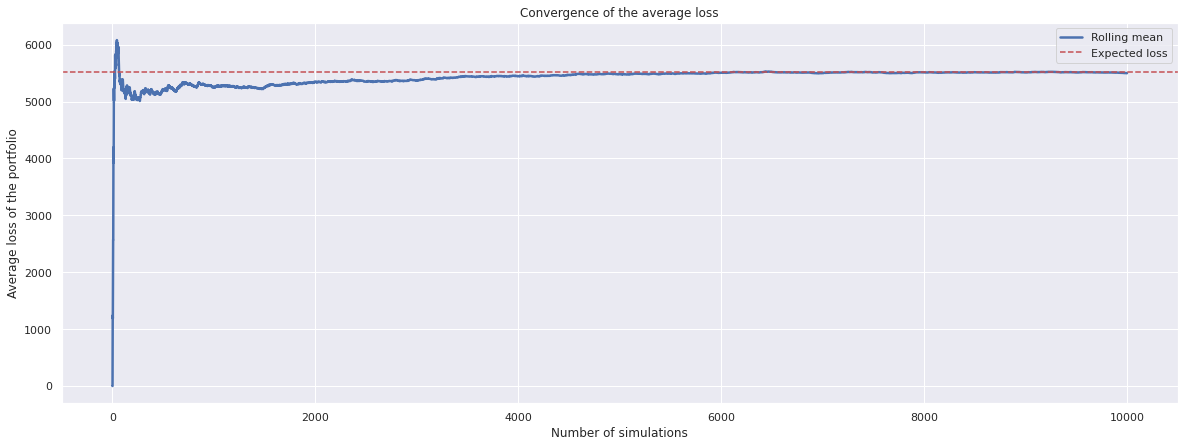

In [ ]:
# Display the rolling mean of the losses of the portefolio
plotRollingMean(df_losses, df_portfolio_indicators)

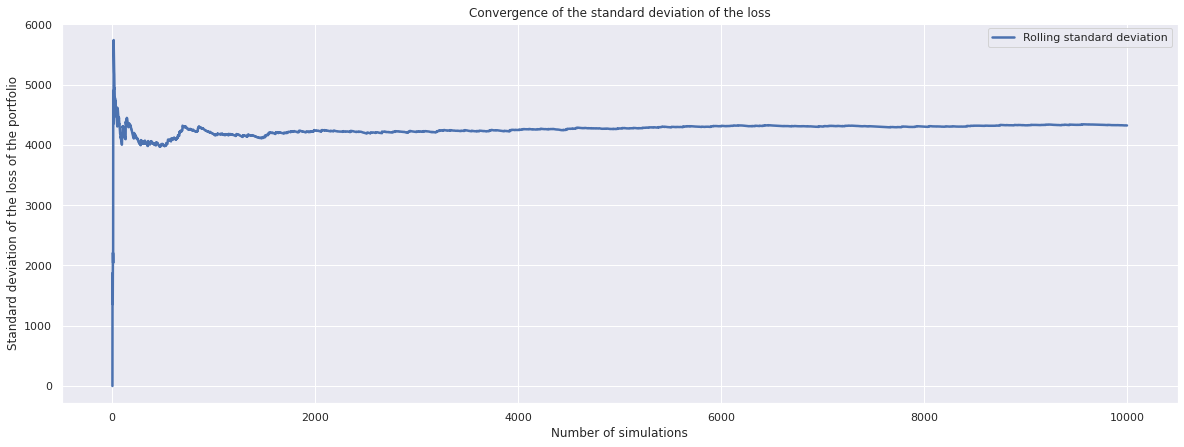

In [ ]:
# Display the rolling standard deviation of the portfolio
plotRollingStdev(df_losses)

# III. Collateralized debt obligations

## 1. Defining function of the CDO

In [ ]:
def cdo(df_losses, df_portfolio, maturity, nb_companies, nb_sectors, nb_simulations, size, strike, rho):
  df_losses = losses(df_portfolio, maturity, nb_companies, nb_sectors, nb_simulations, rho)
  df_cdo = pd.DataFrame(columns=['Losses (%)', 'Tranch ' + str(size) + '%', 'Tranch 100%'], index=[i for i in range(1,nb_simulations+1)])
  df_cdo['Losses (%)'] = (df_losses['Losses']/(df_portfolio['Exposure'].sum()))*100
  df_cdo['Tranch ' + str(size) + '%'] = df_cdo['Losses (%)'] - strike
  df_cdo.loc[df_cdo['Tranch ' + str(size) + '%'] < 0, 'Tranch ' + str(size) + '%'] = 0
  df_cdo.loc[df_cdo['Tranch ' + str(size) + '%'] > size, 'Tranch ' + str(size) + '%'] = size
  df_cdo['Tranch 100%'] = (df_cdo['Tranch ' + str(size) + '%']/size)*100
  price = (df_cdo['Tranch 100%'].mean()/100)*(df_portfolio['Exposure'].sum())*(size/100)
  return df_cdo, price

## 2. The CDO study of the portfolio

In [ ]:
# Parameters of the CDO
maturity, size, strike =  df_cdoTranch['Maturity'][0], df_cdoTranch['Size'][0]*100, df_cdoTranch['Strike'][0]*100
# Compute the price and the CDO tranch
df_cdo, price = cdo(df_losses, df_portfolio, maturity, nb_companies, nb_sectors, nb_simulations, size, strike, rho)
print('The price is : {:.2f}k€'.format(price))
df_cdo

The price is : 643.24k€


,Losses (%),Tranch 2.0%,Tranch 100%
1,6.981620,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,5.750730,0.000000,0.000000
4,3.484844,0.000000,0.000000
5,7.357267,0.357267,17.863353
...,...,...,...
9996,5.844019,0.000000,0.000000
9997,11.467197,2.000000,100.000000
9998,7.199599,0.199599,9.979953
9999,6.862607,0.000000,0.000000


# IV. Graphical user interface

## 1. The main interactive function


In [ ]:
def interactiveStudies(isConfidence, isGlobalCorrelation, isMaturity, isSize, isStrike):
  "Input : Arrays of all the parameters to test"
  "Output : An interactive graphical user interface based on portfolio management and CDO studies"
  df_isLosses = losses(df_portfolio, isMaturity, nb_companies, nb_sectors, nb_simulations, isGlobalCorrelation)
  df_isPortfolio_indicators = portfolioIndicators(isConfidence, df_isLosses, df_portfolio, isMaturity)
  df_isCdo, isPrice = cdo(df_isLosses, df_portfolio, isMaturity, nb_companies, nb_sectors, nb_simulations, isSize, isStrike, isGlobalCorrelation)
  Fig, axs = plt.subplots(2)
  print('--------------------------------------------------------------------------------------')
  print('There, you can take a look at your portfolio :')
  display(df_portfolio)
  print('')
  print('The main indicators of your portfolio are :')
  display(df_isPortfolio_indicators)
  print('')
  print('Take a look at the convergence of the average loss of your portflio')
  axs[0].plot(df_isLosses['Rolling mean'])
  axs[0].set_label('Loss rolling mean')
  isExpectedLoss = axs[0].axhline(df_isPortfolio_indicators['Expected losses'][1], color='r', linestyle='--')
  isExpectedLoss.set_label('Expected loss')
  axs[0].legend(['Rolling mean', 'Expected loss'])
  axs[0].set_ylabel('Average loss')
  axs[0].set_title('Convergence of the average loss')
  print('')
  print('Now, there is the convergence of the standard deviation of the loss of your portfolio')
  axs[1].plot(df_isLosses['Rolling stdev'], color='b',linewidth=2.5)
  axs[1].set_label('Rolling standard deviation')
  axs[1].legend(['Rolling standard deviation'])
  axs[1].set_ylabel('Standard deviation of the loss')
  axs[1].set_xlabel('Number of simulations')
  axs[1].set_title('Convergence of the standard deviation of the loss')
  print('--------------------------------------------------------------------------------------')
  print('Collateralized debt obligations')
  print('')
  print('The price is : {:.2f}k€'.format(isPrice))

## 2. The studies

### 2.1. Data preprocessing

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1Fx8p4A9mjzqUCIT6piNN2atUwH7U2yzZ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Portfolio.xlsx')  
df_param, df_portfolio, df_rating, df_sector, df_cdoTranch = pd.read_excel('Portfolio.xlsx', sheet_name='Param'), pd.read_excel('Portfolio.xlsx', sheet_name='Portfolio'), pd.read_excel('Portfolio.xlsx', sheet_name='Rating'), pd.read_excel('Portfolio.xlsx', sheet_name='Sector'),pd.read_excel('Portfolio.xlsx', sheet_name='CDO Tranch')

In [ ]:
# Data processing
df_portfolio = df_portfolio.merge(df_rating,how='left', on='Rating',sort=False).merge(df_sector,how='left', on='Sector',sort=False)
df_portfolio = df_portfolio.set_index('Id')
df_rating = df_rating.set_index('Rating')
df_sector = df_sector.set_index('Sector')
df_cdoTranch = df_cdoTranch.set_index('CDO Tranch')

In [ ]:
nb_companies = len(df_portfolio.index)
nb_sectors = len(df_sector.index)
nb_simulations = df_param['Nsimul'][0]
maturities = ['1Y', '3Y', '5Y']
confidences = [0.90, 0.95, 0.99]
globalCorrelations = widgets.FloatSlider(min = 0, max = 1, step = 0.01)
strikes = widgets.IntSlider(min = 1, max = 100, step = 1)
sizes = widgets.IntSlider(min = 0, max = 100, step = 1)
interact_manual(interactiveStudies, isConfidence = confidences, isGlobalCorrelation = globalCorrelations, isMaturity = maturities, isSize = sizes, isStrike = strikes)

interactive(children=(Dropdown(description='isConfidence', options=(0.9, 0.95, 0.99), value=0.9), FloatSlider(…

<function __main__.interactiveStudies>